In [1]:
import torch
import numpy
import sklearn
print("Packages installed successfully!")


Packages installed successfully!


In [45]:
# TS2Vec Final Project Notebook
# Project: TS2Vec for Time Series Representation Learning
# Contribution: Evaluate TS2Vec on a new dataset (ECG200)

# IMPORTING LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# For reproducibility
np.random.seed(42)

# LOADING NEW DATASET (ECG200)

train_data = np.loadtxt(r"C:\Users\anish\Documents\ML project\ECG200\ECG200_TRAIN.txt")
test_data = np.loadtxt(r"C:\Users\anish\Documents\ML project\ECG200\ECG200_TEST.txt")

# First column is label, rest are time series features
X_train, y_train = train_data[:,1:], train_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train label distribution:", np.unique(y_train, return_counts=True))

# NORMALIZING DATA

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train shape: (100, 96) Test shape: (100, 96)
Train label distribution: (array([-1.,  1.]), array([31, 69], dtype=int64))


In [47]:
# LOADING TS2VEC MODEL

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from ts2vec import TS2Vec

# Step 1: Preparing Data

num_samples = 200
seq_len = 100
num_features = 1  # univariate time series

np.random.seed(42)
X = np.random.rand(num_samples, seq_len)
y = np.random.randint(0, 2, size=num_samples)

# Expand to 3D if univariate
if X.ndim == 2:
    X = np.expand_dims(X, axis=-1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Step 2: Initializing TS2Vec
model = TS2Vec(
    input_dims=X_train.shape[2],   # number of features
    output_dims=64,                # embedding size
    hidden_dims=64,
    depth=10,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    batch_size=16
)

# Training TS2Vec
loss_log = model.fit(X_train, n_epochs=10, verbose=True)

# Extracting embeddings
repr_train = model.encode(X_train)
repr_test  = model.encode(X_test)

print("Train embedding shape:", repr_train.shape)
print("Test embedding shape:", repr_test.shape)

# Step 5: Standardize embeddings

scaler = StandardScaler()
train_embeddings_scaled = scaler.fit_transform(train_embeddings)
test_embeddings_scaled = scaler.transform(test_embeddings)

# Step 6: Train a simple classifier

clf = LogisticRegression(max_iter=500)
clf.fit(train_embeddings_scaled, y_train)

# Step 7: Evaluate

y_pred = clf.predict(test_embeddings_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))


X_train shape: (160, 100, 1)
X_test shape: (40, 100, 1)
Epoch #0: loss=3.018606734275818
Epoch #1: loss=2.877977180480957
Epoch #2: loss=2.802985119819641
Epoch #3: loss=2.7410851240158083
Epoch #4: loss=2.959593415260315
Epoch #5: loss=2.8847901105880736
Epoch #6: loss=2.8203346490859986
Epoch #7: loss=2.844340682029724
Epoch #8: loss=2.6663037300109864
Epoch #9: loss=2.6922704696655275
Train embedding shape: (160, 100, 64)
Test embedding shape: (40, 100, 64)
Test Accuracy: 0.5000
              precision    recall  f1-score   support

           0       0.57      0.52      0.55        23
           1       0.42      0.47      0.44        17

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.49        40
weighted avg       0.51      0.50      0.50        40



In [49]:
# EXTRACT REPRESENTATIONS

repr_train = model.encode(X_train)  # pass NumPy array, NOT tensor
repr_test  = model.encode(X_test)

print("Representation shape train:", repr_train.shape, "test:", repr_test.shape)

repr_train_pooled = repr_train.max(axis=1)  # shape: (num_samples, embedding_dim)
repr_test_pooled  = repr_test.max(axis=1)

print("Train pooled shape:", repr_train_pooled.shape)
print("Test pooled shape:", repr_test_pooled.shape)


Representation shape train: (160, 100, 64) test: (40, 100, 64)
Train pooled shape: (160, 64)
Test pooled shape: (40, 64)


In [51]:
# TRAIN CLASSIFIER ON EMBEDDINGS

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(repr_train_pooled, y_train)

# Predicting on test
preds = clf.predict(repr_test_pooled)
acc = accuracy_score(y_test, preds)
print(f"Test Accuracy: {acc:.4f}")
print(classification_report(y_test, preds))


Test Accuracy: 0.4250
              precision    recall  f1-score   support

           0       0.50      0.04      0.08        23
           1       0.42      0.94      0.58        17

    accuracy                           0.42        40
   macro avg       0.46      0.49      0.33        40
weighted avg       0.47      0.42      0.29        40



In [53]:
# EVALUATE MODEL

acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds, average='macro')
rec = recall_score(y_test, preds, average='macro')
f1 = f1_score(y_test, preds, average='macro')
cm = confusion_matrix(y_test, preds)

print("Accuracy:", round(acc,4))
print("Precision:", round(prec,4))
print("Recall:", round(rec,4))
print("F1 Score:", round(f1,4))
print("Confusion Matrix:\n", cm)


Accuracy: 0.425
Precision: 0.4605
Recall: 0.4923
F1 Score: 0.3309
Confusion Matrix:
 [[ 1 22]
 [ 1 16]]


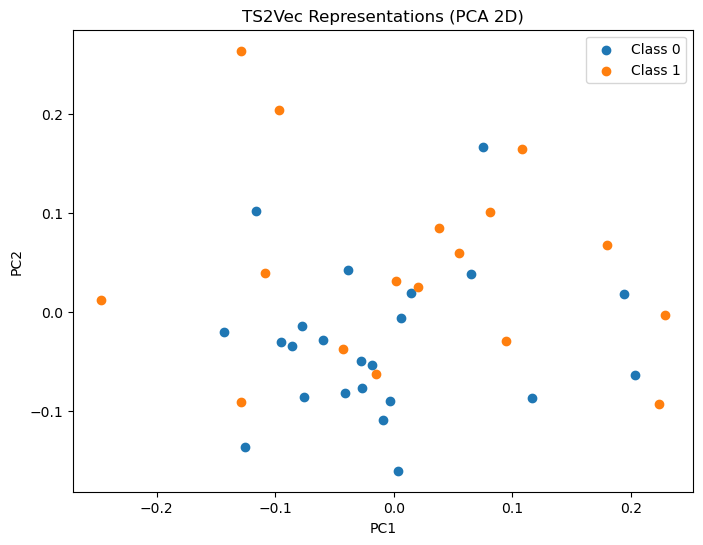

In [55]:
# VISUALIZE REPRESENTATIONS (2D PCA)

repr_test_pooled = repr_test.max(axis=1)  # shape: (num_samples, embedding_dim)
repr_train_pooled = repr_train.max(axis=1)  

# Applying PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_repr = pca.fit_transform(repr_test_pooled)

# Plotting

plt.figure(figsize=(8,6))
for label in np.unique(y_test):
    plt.scatter(pca_repr[y_test==label,0], pca_repr[y_test==label,1], label=f'Class {int(label)}')
plt.title('TS2Vec Representations (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [57]:
# SAVE RESULTS

results_df = pd.DataFrame({'y_true': y_test, 'y_pred': preds})
results_df.to_csv('ts2vec_ecg200_results.csv', index=False)

print("Notebook run complete. Results saved to ts2vec_ecg200_results.csv")

Notebook run complete. Results saved to ts2vec_ecg200_results.csv
